In [238]:
import numpy as np
import scipy.optimize
import sklearn
from utils.mean_covariance import *

implementing the following function

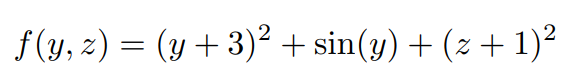

In [239]:
def pos_sin(dim_2_arr):
    y = dim_2_arr[0]
    z = dim_2_arr[1]
    return pow((y + 3), 2) + np.sin(y) + pow((z+1), 2)

In [240]:
# define parameters to put insie the function
params = np.array([0,0], dtype=np.int16)

# x: estimated position of the minimum
# f: is the objective value at the minimum
# d: additional information
# d['funcalls']: number of times 'func' was called

# apporx_grad = true: The gradiant is approximately numerically
x, f, d = scipy.optimize.fmin_l_bfgs_b(func=pos_sin, x0=params, approx_grad=True)

print(f'estimated position "x"\t->\tx[0]: {x[0]}\t x[1]: {x[1]}')
print(f'objective value "f": {f}')
print(f"d['funcalls']: {d['funcalls']}")

estimated position "x"	->	x[0]: -2.577471382130981	 x[1]: -0.9999992747814318
objective value "f": -0.3561430123647567
d['funcalls']: 21


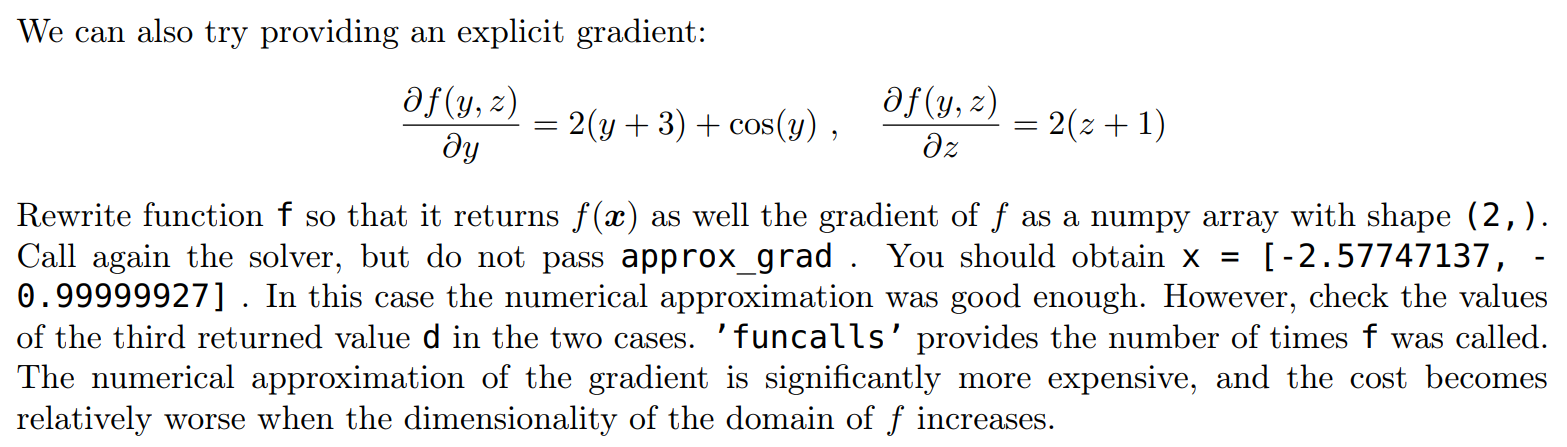

In [241]:
def pos_sin_grad(dim_2_arr):
    y = dim_2_arr[0]
    z = dim_2_arr[1]
    
    # compute gradiant
    df_dy = 2*(y+3) + np.cos(y)
    df_dz = 2*(z+1)
    
    res_fn = pow((y + 3), 2) + np.sin(y) + pow((z + 1), 2)
    res_grad =  np.array([df_dy, df_dz], dtype=np.float64)
    
    return res_fn, res_grad

In [242]:
#calling the solver again

params = np.array([0,0], dtype=np.int16)

x, f, d = scipy.optimize.fmin_l_bfgs_b(func=pos_sin_grad, x0=params)

print(f'estimated position "x"\t->\tx[0]: {x[0]}\t x[1]: {x[1]}')
print(f'objective value "f": {f}')
print(f"d['funcalls']: {d['funcalls']}")

estimated position "x"	->	x[0]: -2.577471374036827	 x[1]: -0.999999269397354
objective value "f": -0.3561430123647611
d['funcalls']: 7


Without numerical approximation (approx_grad = True) the computation of the gradient is expensive. Indeed in the first case(with approx_grad) the function is called 21 times, in the second case (no approx_grad) the function is called just 7 times.

### Binary Logistic Regression

We can now turn our attention to Logistic Regression. In this section we will implement the binary
version of the logistic regression to discriminate between iris virginica and iris versicolor. We will ignore
iris setosa. We will represent labels with 1 (iris versicolor) and 0 (iris virginica).

In [243]:
import sklearn.datasets


def load_iris_binary():
    D = sklearn.datasets.load_iris()['data'].T
    L = sklearn.datasets.load_iris()['target']
    D = D[:, L != 0]    # removing setosa from D
    L = L[L!=0]         # removing setosa from L
    L[L==2] = 0         # assigning label 0 to virginica
    return D, L

In [244]:
def split_db_2to1(D, L, seed=0):
    nTrain = int(D.shape[1]*2.0/3.0)
    np.random.seed(seed)
    idx = np.random.permutation(D.shape[1])
    idxTrain = idx[0:nTrain]
    idxTest = idx[nTrain:]
    DTR = D[:, idxTrain]
    DTE = D[:, idxTest]
    LTR = L[idxTrain]
    LTE = L[idxTest]
    return (DTR, LTR), (DTE, LTE)

In [245]:
D, L = load_iris_binary()
(DTR, LTR), (DVAL, LVAL) = split_db_2to1(D, L)

print(f'DTR shape: {DTR.shape}')
print(f'LTR shape: {LTR.shape}')
print(f'DVAL shape: {DVAL.shape}')
print(f'LVAL shape: {LVAL.shape}')

DTR shape: (4, 66)
LTR shape: (66,)
DVAL shape: (4, 34)
LVAL shape: (34,)


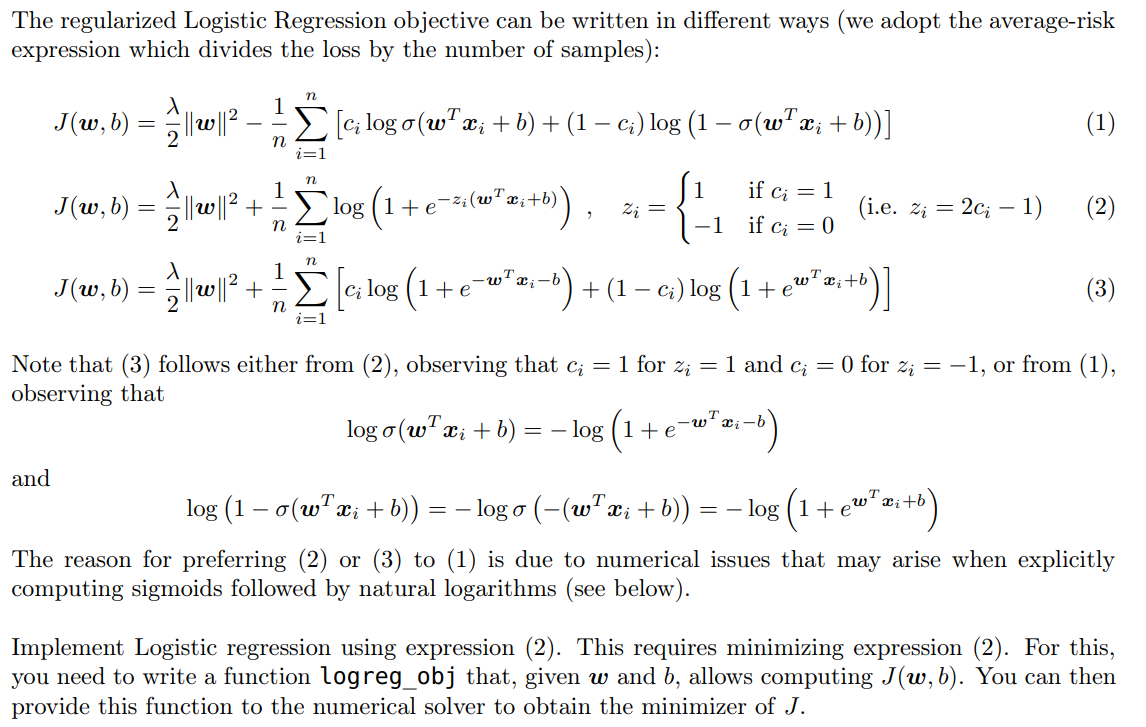

### 1) METHOD: logreg_obj embedded in trainLogReg

In [246]:
# l: lambda

def trainLogRegBinary(DTR, LTR, l):
    
    def logreg_obj(v):
        w = v[0: -1]
        b = v[-1]
        
        # number of samples
        n = DTR.shape[1]
        
        # computing (2) objective function
        sum = 0
        S = (vcol(w).T @ DTR + b).ravel()   # (66,)
        ZTR = 2 * LTR - 1   # (66,)
        vec_log = np.logaddexp(0, -ZTR * S)
        for elem in vec_log:
            sum += elem
        
        return l/2 * np.dot(w,w) + 1/n * sum
    
    xf = scipy.optimize.fmin_l_bfgs_b(func = logreg_obj, x0 = np.zeros(DTR.shape[0] + 1), approx_grad=True)[0]
    return xf

In [247]:
xf = trainLogRegBinary(DTR, LTR, 0.01)
print(f'xf.shape: {xf.shape}')
print(f'xf: {xf}')

xf.shape: (5,)
xf: [ 0.55673328  0.35523501 -2.78053935 -2.76755738 13.96308481]


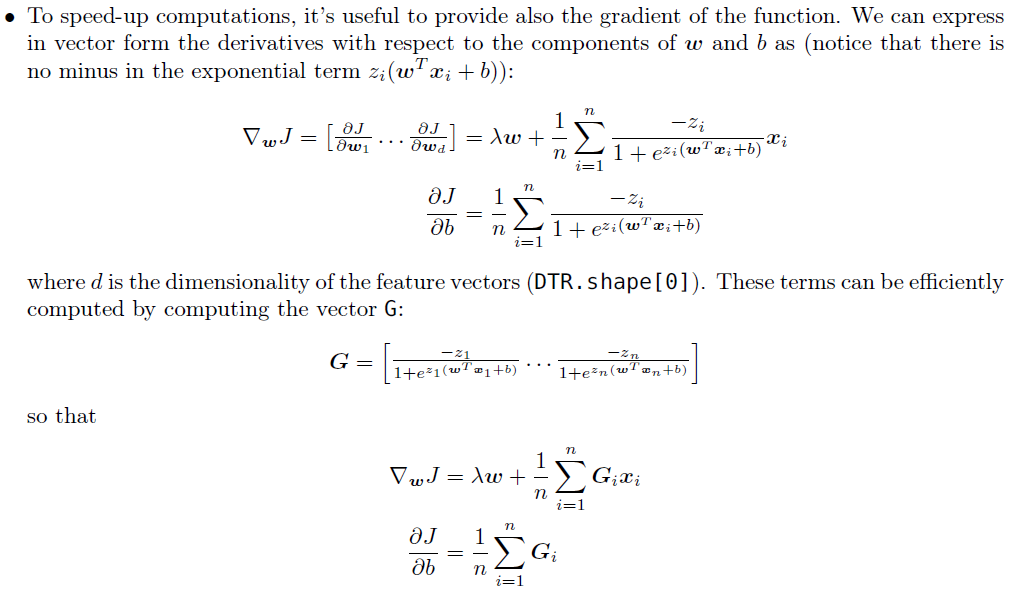

function written with gradient implementation

trainLogRegBinary() second version

In [248]:
# lambda

def trainLogRegBinary(DTR, LTR, l):
    ZTR = LTR * 2.0 - 1.0  # Convert labels to -1 / +1

    def logreg_obj_with_grad(v):
        w = v[:-1]
        b = v[-1]
        S = np.dot(vcol(w).T, DTR).ravel() + b  # Shape: (n_samples,)

        # Loss: average log-loss with regularization
        loss = np.logaddexp(0, -ZTR * S)  # Vectorized
        J = loss.mean() + (l / 2) * np.linalg.norm(w)**2

        # Gradient computation
        G = -ZTR / (1.0 + np.exp(ZTR * S))  # Shape: (n_samples,)
        GW = (vrow(G) * DTR).mean(axis=1) + l * w  # Gradient w.r.t. w
        Gb = G.mean()  # Gradient w.r.t. b

        grad = np.hstack([GW, np.array(Gb)])
        return J, grad

    # Initialize w and b to 0
    x0 = np.zeros(DTR.shape[0] + 1)

    # Minimize the objective
    vf, _, _ = scipy.optimize.fmin_l_bfgs_b(logreg_obj_with_grad, x0=x0)
    
    # Compute final J at the solution
    J_opt, _ = logreg_obj_with_grad(vf)
    
    # Return optimized w and b
    return vf[:-1], vf[-1], J_opt

In [249]:
w, b, J_opt = trainLogRegBinary(DTR, LTR, 0.01)
print(f'w: {w}')
print(f'b: {b}')
print(f'J_opt: {J_opt}')

w: [ 0.55673227  0.35523454 -2.7805404  -2.76755686]
b: 13.96309687482952
J_opt: 0.24296227288068295


Once you have trained the model, you can compute posterior log-probability ratios by simply computing,
for each test sample xt, the score



In [250]:
def compute_score(D, w, b):
    return (vcol(w).T @ D + b).ravel()

def compute_llr(D, w, b, emp):
    return (compute_score(D, w, b) - np.log(emp/(1-emp))).ravel()

def compute_pred(S):
    """
    making predictions with S
    """

    vec_pred = []
    for score in S:
        pred = 1 if score > 0 else 0
        vec_pred.append(pred)
    return vec_pred

def comput_error_rate(LP, L):
    err_rate = 0
    tot = L.shape[0]
    
    count = 0   # count mispredicted element
    for lp, l in zip(LP, L):
        if lp != l:
            count += 1
            
    err_rate = count/tot
    return err_rate

In [251]:

S = compute_score(DVAL, w, b)
print(f'S.shape: {S.shape}')
print(f'S: {S}')

S.shape: (34,)
S: [ 3.98610148 -1.16283235  4.50320837 -1.92101099  4.0804638   5.56063233
  3.13308794 -1.34636358 -2.75766458  0.03096916  0.0563715  -3.9024954
 -4.92014238 -0.181383    2.59427608  2.45534791 -3.61939926  2.89055735
  3.19322516 -2.439311   -2.52744727  4.19528799  0.04099782 -3.27316103
 -1.64716411  1.57455495  3.63383488  0.13307552  3.09855075 -0.80246354
 -5.11841921 -2.63609178  2.89086944  2.76383722]


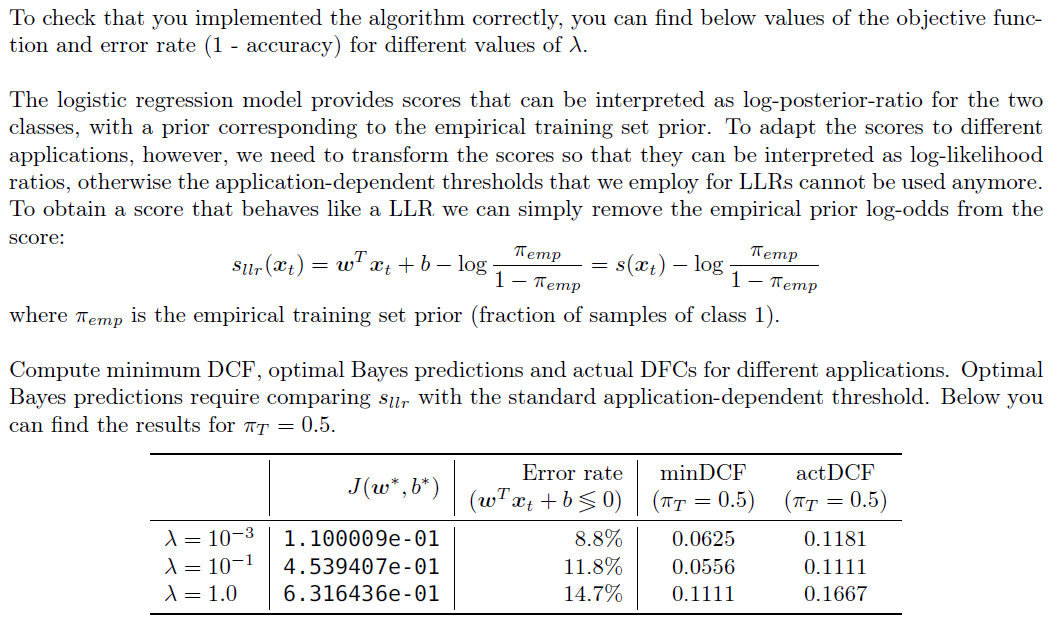

In [252]:
emp_1 = np.sum(LTR == 1)/LTR.shape[0]

In [253]:
S_llr = compute_llr(DVAL, w, b, emp_1)

print(f'S_llr: {S_llr}')

S_llr: [ 3.92547685e+00 -1.22345698e+00  4.44258374e+00 -1.98163561e+00
  4.01983918e+00  5.50000771e+00  3.07246332e+00 -1.40698821e+00
 -2.81828921e+00 -2.96554621e-02 -4.25312446e-03 -3.96312002e+00
 -4.98076700e+00 -2.42007620e-01  2.53365146e+00  2.39472328e+00
 -3.68002388e+00  2.82993273e+00  3.13260054e+00 -2.49993562e+00
 -2.58807189e+00  4.13466337e+00 -1.96268060e-02 -3.33378565e+00
 -1.70778873e+00  1.51393033e+00  3.57321026e+00  7.24509015e-02
  3.03792612e+00 -8.63088163e-01 -5.17904383e+00 -2.69671640e+00
  2.83024482e+00  2.70321260e+00]


In [257]:
lambda_val = [0.001, 0.1, 1]

for l in lambda_val:
    w, b, J_opt = trainLogRegBinary(DTR, LTR, l)
    S = compute_score(DVAL, w, b)
    LP = compute_pred(S)
    err_rate = comput_error_rate(LP, LVAL)
    
    print(f'l: {l:10.2e}\tJ_opt: {J_opt}\terr_rate: {err_rate}')

l:   1.00e-03	J_opt: 0.11000090354987913	err_rate: 0.08823529411764706
l:   1.00e-01	J_opt: 0.4539406895957473	err_rate: 0.11764705882352941
l:   1.00e+00	J_opt: 0.6316436205354085	err_rate: 0.14705882352941177
